In [24]:
import pandas as pd
import numpy as np

In [25]:
df0 = pd.read_csv("Noah_5Years_000.csv", skiprows=4)
df1 = pd.read_csv("Noah_5Years_002.csv", skiprows=4)
df2 = pd.read_csv("Noah_5Years_003.csv", skiprows=4)

df = pd.concat([df0, df1, df2])
df = df[['Timestamp', 'Noah - Water Use (gal)']]
df[['Date', 'Time']] = df['Timestamp'].str.split(' ', expand = True)
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day_name()
df = df[['Date', 'Year', 'Month', 'Day', 'Time', 'Noah - Water Use (gal)']]

df.dropna(inplace=True)

df['Time'] = pd.to_datetime(df['Time']).dt.time

from datetime import time
df = df[df['Time'] >= time(8)]

# year_bool_array = (df['Year'] >= 2021) | (df['Year'] <= 2019)
# month_bool_array = ((df['Month'] >= 9) & (df['Month'] <= 12)) | ((df['Month'] >= 2) & (df['Month'] <= 5))

# df = df[year_bool_array & month_bool_array].reset_index(drop=True)
df = df.reset_index(drop=True)
start = df[df['Date'] == '2022-01-01'].iloc[0].name
end = df[df['Date'] == '2022-12-31'].iloc[-1].name

df_test = df.iloc[start: end]
df = df.iloc[: start]

df = df[['Month', 'Day', 'Time', 'Noah - Water Use (gal)']]
df.columns = ['Month', 'Day', 'Time', 'Water']
df


,Month,Day,Time,Water
0,1,Monday,08:00:00,0.00000
1,1,Monday,08:15:00,0.00000
2,1,Monday,08:30:00,0.00000
3,1,Monday,08:45:00,0.00000
4,1,Monday,09:00:00,0.00000
...,...,...,...,...
58063,12,Friday,22:45:00,2.28294
58064,12,Friday,23:00:00,4.01284
58065,12,Friday,23:15:00,7.57591
58066,12,Friday,23:30:00,0.27672


In [26]:
pd.to_datetime('00:00') > pd.to_datetime('07:00')

False

In [27]:
df.isnull().any()

Month    False
Day      False
Time     False
Water    False
dtype: bool

In [28]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

X = df.drop('Water', axis=1)
y = df['Water']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train_transformed = OneHotEncoder().fit_transform(X_train)
X_test_transformed = OneHotEncoder().fit_transform(X_test)


In [29]:
rgs = MLPRegressor(hidden_layer_sizes=(10,))
rgs.fit(X_train_transformed, y_train)
y_pred = rgs.predict(X_test_transformed)

c:\Users\admin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [30]:
pd.Series(y_pred)

0         5.632878
1        18.338551
2        16.995094
3         9.498843
4         3.726859
           ...    
14512    17.415862
14513    22.316871
14514    14.624668
14515     6.936420
14516     5.231626
Length: 14517, dtype: float64

In [31]:
y_test

1183      3.63225
16090    23.21179
31695     7.47174
503      13.97466
45647     0.00000
           ...   
39954    28.98742
3899     14.07933
9201      1.55675
10634     0.00000
11147     0.00000
Name: Water, Length: 14517, dtype: float64

In [32]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.27810831674216807

In [33]:
df_test = df_test.reset_index(drop=True)
df_test.columns = ['Date', 'Year',	'Month',	'Day',	'Time',	'Water']
df_test

,Date,Year,Month,Day,Time,Water
0,2022-01-01,2022,1,Saturday,08:00:00,1.59134
1,2022-01-01,2022,1,Saturday,08:15:00,0.24213
2,2022-01-01,2022,1,Saturday,08:30:00,0.65721
3,2022-01-01,2022,1,Saturday,08:45:00,0.17295
4,2022-01-01,2022,1,Saturday,09:00:00,0.20754
...,...,...,...,...,...,...
23316,2022-12-31,2022,12,Saturday,22:30:00,1.34901
23317,2022-12-31,2022,12,Saturday,22:45:00,0.86475
23318,2022-12-31,2022,12,Saturday,23:00:00,3.35533
23319,2022-12-31,2022,12,Saturday,23:15:00,2.83638


In [34]:
b = df_test.groupby('Date').apply(lambda d: d.iloc[d['Water'].argmin()]['Time']) 
b

Date
2022-01-01    08:45:00
2022-01-02    11:00:00
2022-01-03    16:30:00
2022-01-04    15:30:00
2022-01-05    20:45:00
                ...   
2022-12-27    14:00:00
2022-12-28    11:30:00
2022-12-29    11:00:00
2022-12-30    23:45:00
2022-12-31    10:30:00
Length: 365, dtype: object

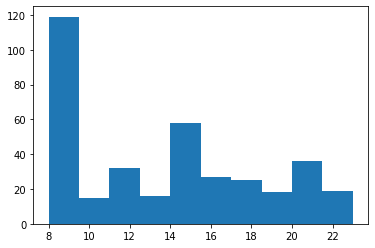

In [35]:
import matplotlib.pyplot as plt
plt.figure()
c = b.apply(lambda x: x.hour)
plt.hist(c)
plt.show()

In [36]:
X_test1 = df_test[['Month', 'Day', 'Time']]
X_test1_tranformed = OneHotEncoder().fit_transform(X_test1)
X_test1['Water'] = rgs.predict(X_test1_tranformed)
X_test1['Date'] = df_test['Date']
a = X_test1.groupby('Date').apply(lambda d: d.iloc[d['Water'].argmin()]['Time']) 
print(a.head(20))

Date
2022-01-01    08:00:00
2022-01-02    08:00:00
2022-01-03    15:15:00
2022-01-04    15:15:00
2022-01-05    15:15:00
2022-01-06    15:15:00
2022-01-07    16:15:00
2022-01-08    08:00:00
2022-01-09    08:00:00
2022-01-10    15:15:00
2022-01-11    15:15:00
2022-01-12    15:15:00
2022-01-13    15:15:00
2022-01-14    16:15:00
2022-01-15    08:00:00
2022-01-16    08:00:00
2022-01-17    15:15:00
2022-01-18    15:15:00
2022-01-19    15:15:00
2022-01-20    15:15:00
dtype: object


C:\Users\admin\AppData\Local\Temp\ipykernel_12620\973957269.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test1['Water'] = rgs.predict(X_test1_tranformed)
C:\Users\admin\AppData\Local\Temp\ipykernel_12620\973957269.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test1['Date'] = df_test['Date']


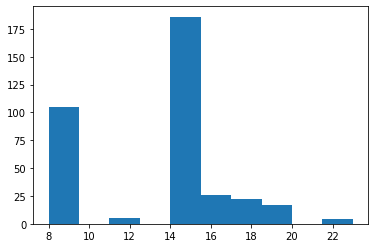

In [37]:
plt.figure()
c = a.apply(lambda x: x.hour)
plt.hist(c)
plt.show()